# Overview

This notebook trains 5 models using *author positions* as the feature, including 1 regression model (Ridge Regression) and 4 classification models (Logistic Classification, Decision Tree, Adaboost, and SVM).

We first start with the preprocessing steps of loading the dataframes and transforming certain columns so they can be used directly.

Then, we proceed to model trainings and interpreting variable importances.

# Preprocessing

In [ ]:
# load imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import plotly.express as px
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import json
import matplotlib.pyplot as plt

In [ ]:
# load data sets

train_df = pd.read_csv('drive/MyDrive/CIS520 Project/data set/train_name_pos_tag.csv')
test_df = pd.read_csv('drive/MyDrive/CIS520 Project/data set/test_name_pos_tag.csv')
test_df_upsampled = pd.read_csv('drive/MyDrive/CIS520 Project/data set/test_df_upsampled.csv')


# parse authors, tags, and author positions columns from JSON string to lists
def parse_json(df):
  df['authors'] = df['authors'].apply(lambda x : json.loads(x))
  df['tags'] = df['tags'].apply(lambda x : json.loads(x))
  df['author_positions'] = df['author_positions'].apply(lambda x : json.loads(x))
  return df

train_df = parse_json(train_df)
test_df = parse_json(test_df)
test_df_upsampled = parse_json(test_df_upsampled)

In [ ]:
# combine the list of author names, tags and author positions into
# a comma separted string

def transform_meta(df):
  cols = ['authors', 'tags', 'author_positions']
  for col in cols:
    df[col] = df[col].apply(lambda x : ', '.join(x))
  
  return df

train_df = transform_meta(train_df)
test_df = transform_meta(test_df)
test_df_upsampled = transform_meta(test_df_upsampled)

In [ ]:
# get quintiles for train data
train_df['quintile'] = pd.cut(train_df['percentile'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [1,2,3,4,5])
# get quintiles for the test data
test_df['quintile'] = pd.cut(test_df['percentile'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [1,2,3,4,5])

# Get top 25% vs bottom 75%
train_df['top25pct'] = (train_df['percentile'] >= 0.75).astype(int)
test_df['top25pct'] = (test_df['percentile'] >= 0.75).astype(int)

train_df['published_date'] = train_df['published_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_df['published_date'] = test_df['published_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
# Returns the training and test data within the window
def get_window(train_df, test_df, date_start, months):
  date_end = date_start + relativedelta(months = +months)
  train_window = train_df.loc[(train_df['published_date'] >= date_start) & (train_df['published_date'] < date_end), :]
  test_window = test_df.loc[(test_df['published_date'] >= date_start) & (test_df['published_date'] < date_end), :]
  return train_window, test_window

In [ ]:
def upsample_minority(df):

  # Upsample minority class in both the training and test data
  df_majority = df.loc[df['top25pct'] == 0, :]
  df_minority = df.loc[df['top25pct'] == 1, :]
  df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

  # Combine together to get the upsampled training data
  df = pd.concat([df_majority, df_minority_upsampled])

  return df

**Count Vectorization of Words**

In [ ]:
# Input: train, test dataframe, feature
# Output: train_titles, test_titles vectorized matrix (#doc x #words)
def convert_text_to_vectors(train_data, test_data, max_words = 2000, use_tfidf = False):

  # Doing the Vectorization of the text
  if use_tfidf == False:
    vectorizer = CountVectorizer(stop_words='english', max_features = max_words)
  else:
    vectorizer = TfidfVectorizer(stop_words = 'english', max_features = max_words)

  # tokenize and build vocab
  vectorizer.fit(train_data['author_positions'])

  # transform text columns
  X_train = vectorizer.transform(train_data['author_positions']).toarray()
  X_test = vectorizer.transform(test_data['author_positions']).toarray()

  return X_train, X_test, vectorizer

# Model Trainings

## Ridge Regression

Regression model on percentiles

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

In [ ]:
# Create and fit model

def train_ridge(X_train, X_test, y_train, y_test, alpha = 1):
  reg = Ridge(alpha = alpha)
  reg.fit(X_train, y_train)
  y_train_pred = reg.predict(X_train)

  # Training MSE and MAE
  rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
  mae = mean_absolute_error(y_train, y_train_pred)

  print('Training RMSE: {}, MAE: {}'.format(rmse , mae))

  # Fit on test data
  y_test_pred = reg.predict(X_test)
  
  # Training MSE and MAE
  rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
  mae = mean_absolute_error(y_test, y_test_pred)
  print('Test RMSE: {}, MAE: {}'.format(rmse , mae))

  return y_train_pred, y_test_pred, reg

In [ ]:
# Variable Importance

def get_variable_importance(reg, vectorizer, X_train_titles):

  reg_coefs = reg.coef_
  vectorizer_words = vectorizer.get_feature_names()

  word_coefs = {}
  for word, coef in zip(vectorizer_words, reg_coefs):
    word_coefs.update({word:coef})

  # Word Frequency
  word_freq = np.sum(X_train_titles, axis = 0)

  # Number of articles the word appeared in
  word_num_articles = np.sum((X_train_titles > 0).astype(int), axis = 0)

  # Store the top words in a dataframe
  word_coefs_df = pd.DataFrame({'Word': vectorizer_words, 'Frequency': word_freq, 'Articles': word_num_articles, 'Coef': reg_coefs}).sort_values('Coef', ascending = False).reset_index(drop = True)

  return word_coefs_df

In [ ]:
# Run Model on All

# Vectorize words
X_train, X_test, vec = convert_text_to_vectors(train_df, test_df_upsampled, max_words = 2000, use_tfidf = False)
y_percentiles_train = train_df['percentile']
y_percentiles_test = test_df_upsampled['percentile']

# Train ridge regression
y_train_pred, y_test_pred, reg = train_ridge(X_train, X_test, y_percentiles_train, y_percentiles_test, alpha = 20)

# Get the variable importance coefs
word_coefs_df = get_variable_importance(reg, vec, X_train)

# Only choose words appearing more than 50 times
word_coefs_df_top = word_coefs_df.loc[word_coefs_df['Frequency'] > 50, :]

word_coefs_df_top = word_coefs_df_top.reset_index(drop = True)

Training RMSE: 0.2639211065029503, MAE: 0.22401094025464482
Test RMSE: 0.28574421834053254, MAE: 0.2506899873974911


In [ ]:
word_coefs_df_top

,Word,Frequency,Articles,Coef
0,board,1379,1175,0.174439
1,columnist,1874,1282,0.120881
2,staff,367,316,0.075524
3,advertising,57,48,0.067939
4,design,524,436,0.049089
...,...,...,...,...
56,quit,55,55,-0.053919
57,dev,137,136,-0.079978
58,sports,9086,4927,-0.086417
59,opinion,3354,2384,-0.096136


Text(0.5, 1.0, 'Variable Importances for Author Positions')

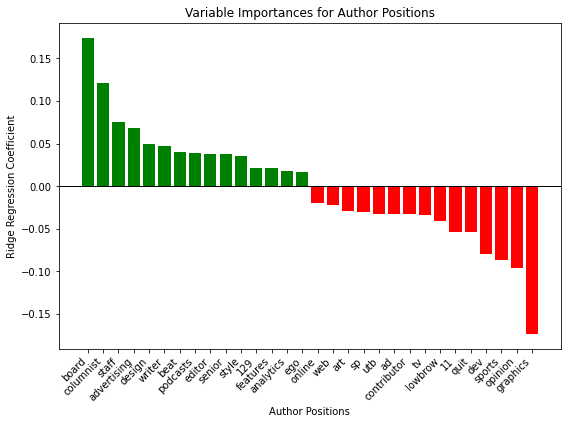

In [ ]:
fig = plt.figure(figsize = (9, 6))

plt.bar(word_coefs_df_top.iloc[0:15, 0], word_coefs_df_top.iloc[0:15, -1], color = 'green')
plt.bar(word_coefs_df_top.iloc[-15:, 0], word_coefs_df_top.iloc[-15:, -1], color = 'red')
fig = plt.xticks(rotation=45, ha="right")
plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.xlabel('Author Positions')
plt.ylabel('Ridge Regression Coefficient')
plt.title('Variable Importances for Author Positions')

In [ ]:
# Save the predictions so that it can be used for ensemble
test_df_upsampled['ridge_predictions_pos'] = y_test_pred

**Rolling Window Predictions**

In [ ]:
# Get a list of start dates
dates = [datetime.fromtimestamp(e.timestamp()) for e in pd.date_range('2013-01-01','2020-05-02', freq='MS')]

word_coefs_df_all = pd.DataFrame()
for start_date in dates:
  print(start_date)
  
  # Segment by window
  train_window, test_window = get_window(train_df, test_df, start_date, 3)
  
  # Vectorize words
  X_train, X_test, vec = convert_text_to_vectors(train_window, test_window, max_words = 2000, use_tfidf = False)
  
  y_percentiles_train = train_window['percentile']
  y_percentiles_test = test_window['percentile']
  
  # Train ridge regression
  y_train_pred, y_test_pred, reg = train_ridge(X_train, X_test, y_percentiles_train, y_percentiles_test, alpha = 20)

  # Get the variable importance coefs
  word_coefs_df = get_variable_importance(reg, vec, X_train)

  word_coefs_df['Month'] = start_date

  word_coefs_df_all = pd.concat([word_coefs_df_all, word_coefs_df], axis = 0)

2013-01-01 00:00:00
Training RMSE: 0.26223462634434735, MAE: 0.22229300764391718
Test RMSE: 0.26988658660432785, MAE: 0.2273201395533504
2013-02-01 00:00:00
Training RMSE: 0.2605868362344168, MAE: 0.22010931184662133
Test RMSE: 0.2822099155944005, MAE: 0.24413733648856745
2013-03-01 00:00:00
Training RMSE: 0.2655987688657741, MAE: 0.22525190827672453
Test RMSE: 0.2777642596864968, MAE: 0.2411014805774146
2013-04-01 00:00:00
Training RMSE: 0.2598338539196564, MAE: 0.21783299293436087
Test RMSE: 0.29056181829185523, MAE: 0.25666202444658
2013-05-01 00:00:00
Training RMSE: 0.25345608012098886, MAE: 0.21387927895276
Test RMSE: 0.3281698976742819, MAE: 0.29499110251521427
2013-06-01 00:00:00
Training RMSE: 0.24122602729425832, MAE: 0.20684378239173454
Test RMSE: 0.31002400446827877, MAE: 0.26400634934174033
2013-07-01 00:00:00
Training RMSE: 0.24685275323993017, MAE: 0.20695628871890048
Test RMSE: 0.2644543219902165, MAE: 0.2184928696640795
2013-08-01 00:00:00
Training RMSE: 0.2560680451843

In [ ]:
top_words=  word_coefs_df_all.groupby('Word')['Frequency'].sum().sort_values(ascending = False).iloc[0:30].index.tolist()
coefs_all = word_coefs_df_all.loc[word_coefs_df_all['Word'].apply(lambda x: x in top_words), :]
coefs_all_pivot = coefs_all.pivot(index = 'Word', columns = 'Month', values = 'Coef')
#coefs_all = coefs_all.fillna(-0.4)

fig = px.line(coefs_all, x = "Month", y = "Coef", color = "Word")
fig.show()

## Logistic Regression

binary classification model on 75-25 buckets

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, recall_score, precision_score, f1_score, auc
from sklearn.linear_model import LogisticRegression

In [ ]:
# function for computing the relevant metrics
# to evaluate a classification model

def get_classification_metrics(actual, pred):
  print(confusion_matrix(actual, pred))
  print('Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}'.format(
      accuracy_score(actual, pred),
      precision_score(actual, pred),
      recall_score(actual, pred),
      f1_score(actual, pred)))

In [ ]:
# Upsample minority
train_df_upsampled = upsample_minority(train_df)

# Vectorize words
X_train_upsampled, X_test_upsampled, vec = convert_text_to_vectors(train_df_upsampled, test_df_upsampled, max_words = 2000, use_tfidf = False)

y_train = train_df_upsampled['top25pct']
y_test = test_df_upsampled['top25pct']

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# function for tuning hyper parameters using GridSearch
def hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test):
    for i in range(len(model_list)):
        print(model_list[i])
        grid_search = GridSearchCV(model_list[i], param_grid_list[i], cv = 5, scoring = 'accuracy')
        grid_search.fit(X_train, y_train)
        print('Best Parameters: {}'.format(grid_search.best_params_))
        best_cross_val_score = grid_search.best_score_
        print('Best Cross Validation Score: {}'.format(best_cross_val_score))
        # Score on the test set
        test_score = grid_search.score(X_test, y_test)
        print('Test Set Score: {}'.format(test_score))

In [ ]:
# Hyper-parameter tuning for Logistic Regression
param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10]}

model_list = [LogisticRegression(max_iter = 1000)]
param_grid_list = [param_grid_logistic]

hyp_tuning(model_list, param_grid_list, X_train_upsampled, y_train, X_test_upsampled, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'C': 0.001}
Best Cross Validation Score: 0.5778556575903491
Test Set Score: 0.6240384615384615


In [ ]:
# running Logistic Regression on the training and testing data sets

clf = LogisticRegression(C=0.001, random_state=0, max_iter=1000)
clf.fit(X_train_upsampled, y_train)

y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[6881 5661]
 [3582 8960]]
Accuracy: 0.6315180991867326, Precision: 0.6128171807673893, Recall: 0.7143996172859193, F1 Score: 0.6597209439310826
Test
[[1721 1399]
 [ 947 2173]]
Accuracy: 0.6240384615384615, Precision: 0.6083426651735723, Recall: 0.6964743589743589, F1 Score: 0.6494321578003587


In [ ]:
# Save the predictions so that it can be used for ensemble
test_df_upsampled['logistic_predictions_pos'] = y_test_pred

## Random Forest

binary classification model on 75-25 buckets

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Get window, Upsample minority, Convert text to vectors already done
clf = RandomForestClassifier(n_estimators = 100, max_depth = 20, max_features = 45, random_state=20)
clf.fit(X_train_upsampled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=45,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[8435 4107]
 [4317 8225]]
Accuracy: 0.6641683941955031, Precision: 0.6669639961076873, Recall: 0.6557965236804337, F1 Score: 0.6613331189193534
Test
[[2074 1046]
 [1293 1827]]
Accuracy: 0.6251602564102564, Precision: 0.6359206404455273, Recall: 0.5855769230769231, F1 Score: 0.6097113298848658


In [ ]:
param_grid_rf = [
    {'max_depth': [40, 45, 50], 'max_features': [50], 'n_estimators': [25]}
]

In [ ]:
# hyper-parameter tuning for random forests

model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, X_train_upsampled, y_train, X_test_upsampled, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 40, 'max_features': 50, 'n_estimators': 25}
Best Cross Validation Score: 0.541417855527252
Test Set Score: 0.6232371794871795


In [ ]:
clf = RandomForestClassifier(max_depth=40, max_features=50, n_estimators=25)
clf.fit(X_train_upsampled, y_train)

y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[8647 3895]
 [4532 8010]]
Accuracy: 0.6640487960452879, Precision: 0.6728265434691306, Recall: 0.6386541221495774, F1 Score: 0.6552951282365934
Test
[[2125  995]
 [1363 1757]]
Accuracy: 0.6221153846153846, Precision: 0.6384447674418605, Recall: 0.5631410256410256, F1 Score: 0.5984332425068121


In [ ]:
# Save the predictions so that it can be used for ensemble
test_df_upsampled['rf_predictions_pos'] = y_test_pred

## Ada Boost

binary classification model on 75-25 buckets

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

learning_rate = 0.1
max_depth = 1
random_state = 20

base_estimator = DecisionTreeClassifier(max_depth=max_depth)
clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=5, learning_rate=learning_rate, random_state=random_state)
clf.fit(X_train_upsampled, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 4398  8144]
 [ 1508 11034]]
Accuracy: 0.6152128847073832, Precision: 0.5753467514860778, Recall: 0.8797639929835752, F1 Score: 0.6957124842370745
Test
[[1106 2014]
 [ 373 2747]]
Accuracy: 0.6174679487179487, Precision: 0.5769796261289645, Recall: 0.8804487179487179, F1 Score: 0.6971196548661337


In [ ]:
# Save the predictions so that it can be used for ensemble

test_df_upsampled['ada_predictions_pos'] = y_test_pred

## SVM

binary classification model on 75-25 buckets

In [ ]:
from sklearn.svm import SVC

# run SVM on several kernel types to see which one gives the best result
list_kernel_type = ['linear', 'poly', 'rbf']
random_state = 20

models = []

for kernel_type in list_kernel_type:
  clf = SVC(kernel=kernel_type, random_state=random_state)
  clf.fit(X_train_upsampled, y_train)
  models.append(clf)

  print(f'----{kernel_type}----\n')
  y_train_pred = clf.predict(X_train_upsampled)
  # Confusion Matrix
  print('Training')
  get_classification_metrics(y_train, y_train_pred)

  # Fit on test data
  y_test_pred = clf.predict(X_test_upsampled)
  print('Test')
  get_classification_metrics(y_test, y_test_pred)
  print('\n')

In [ ]:
y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 4861  7681]
 [ 1587 10955]]
Accuracy: 0.6305214479349386, Precision: 0.5878407383558704, Recall: 0.8734651570722373, F1 Score: 0.7027391109115403
Test
[[1211 1909]
 [ 415 2705]]
Accuracy: 0.6275641025641026, Precision: 0.5862592110966623, Recall: 0.8669871794871795, F1 Score: 0.6995086630462891


In [ ]:
test_df_upsampled['svm_linear_pos'] = y_test_pred

In [ ]:
# save all predictions to a CSV file (to be used for ensemble)

test_df_upsampled.to_csv('test_df_upsampled_pos_predictions.csv', index=False)